In [ ]:
import itk
import glob
import numpy as np
import matplotlib.pyplot as plt
import icon_registration as icon
import icon_registration.networks as networks
import torch
import random

In [56]:
3

3

In [2]:
roots = glob.glob("dxa2d_processed/dxa2d/*")

paths = [sorted(glob.glob(f"{root}/*.dcm")) for root in roots]

In [3]:
knees = []
for path in paths:
    for subpath in path:
        im = np.array(itk.imread(subpath))[0]
        if im.shape[1] == 640:
            knees.append(im)


In [4]:
flipped_knees = []

for im in knees[:84:2]:
    flipped_knees.append(im)
    #plt.imshow(im)
    #plt.show()
    
for im in knees[85::2]:
    flipped_knees.append(im)
    #plt.imshow(im)
    #plt.show()

for im in knees[1:85:2]:
    im = np.flip(im, axis=1)
    flipped_knees.append(im)
    #plt.imshow(im)
    #plt.show()

for im in knees[86::2]:
    im = np.flip(im, axis=1)
    flipped_knees.append(im)
    #plt.imshow(im)
    #plt.show()
    


In [5]:
big_enough_knees = []
for im in flipped_knees:
    if im.shape[0] >= 845:
        big_enough_knees.append(im[:845])
big_enough_knees = torch.tensor(np.array(big_enough_knees))[:, None, :, :] / 255.

test_imgs = big_enough_knees[-10:]
big_enough_knees = big_enough_knees[:-10]

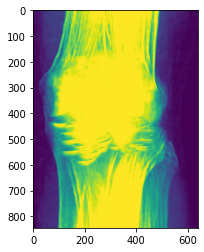

In [6]:
plt.imshow(torch.max(big_enough_knees, axis=0)[0][0])

In [24]:

BATCH_SIZE = 8
inner_net = icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))
for _ in range(3):
    inner_net = icon.TwoStepRegistration(icon.DownsampleRegistration(inner_net, 2), icon.FunctionFromVectorField(networks.tallUNet2(dimension=2)))

netGrad = icon.GradientICON(
    inner_net,
    icon.LNCC(sigma=5),
    3
)
input_shape = big_enough_knees[:1].size()
netGrad.assign_identity_map(input_shape)
netGrad.cuda()
optimizerGrad = torch.optim.Adam(netGrad.parameters(), lr=0.001)
netGrad.train()
0

0

In [25]:
def make_batch():
    idx = range(len(big_enough_knees))
    imgs_idx = [random.choice(idx) for _ in range(BATCH_SIZE)]

    imgs = [big_enough_knees[i:i+1] for i in imgs_idx]
    return torch.cat(imgs).cuda()
    

In [26]:
make_batch().shape

torch.Size([8, 1, 845, 640])

In [27]:
netGrad(make_batch(), make_batch())

ICONLoss(all_loss=tensor(1.9290, device='cuda:0', grad_fn=<AddBackward0>), inverse_consistency_loss=tensor(0., device='cuda:0', grad_fn=<AddBackward0>), similarity_loss=tensor(1.9290, device='cuda:0', grad_fn=<AddBackward0>), transform_magnitude=tensor(0., device='cuda:0', grad_fn=<MeanBackward0>), flips=tensor(0.))

In [87]:
icon.train_batchfunction(netGrad, optimizerGrad, lambda : (make_batch(), make_batch()), steps=2000)

ICONLoss(all_loss=0.04788707569241524, inverse_consistency_loss=0.012414593249559402, similarity_loss=0.01064329594373703, transform_magnitude=0.0021371962502598763, flips=0.0)
ICONLoss(all_loss=0.04399140179157257, inverse_consistency_loss=0.010724086314439774, similarity_loss=0.01181914284825325, transform_magnitude=0.002786071738228202, flips=0.0)
ICONLoss(all_loss=0.047577641904354095, inverse_consistency_loss=0.012033889070153236, similarity_loss=0.011475970968604088, transform_magnitude=0.002056935103610158, flips=0.0)
ICONLoss(all_loss=0.053430818021297455, inverse_consistency_loss=0.012058250606060028, similarity_loss=0.01725606434047222, transform_magnitude=0.0018191937124356627, flips=0.0)
ICONLoss(all_loss=0.042245082557201385, inverse_consistency_loss=0.010066011920571327, similarity_loss=0.012047046795487404, transform_magnitude=0.0024665570817887783, flips=0.0)
ICONLoss(all_loss=0.051673758774995804, inverse_consistency_loss=0.011587679386138916, similarity_loss=0.0169107

ICONLoss(all_loss=0.023792613297700882, inverse_consistency_loss=0.0031231828033924103, similarity_loss=0.014423064887523651, transform_magnitude=0.0018940215231850743, flips=0.0)
ICONLoss(all_loss=0.024977542459964752, inverse_consistency_loss=0.0035170791670680046, similarity_loss=0.014426304027438164, transform_magnitude=0.0038734672125428915, flips=0.0)
ICONLoss(all_loss=0.02443603239953518, inverse_consistency_loss=0.0033872858621180058, similarity_loss=0.014274174347519875, transform_magnitude=0.003509493311867118, flips=0.0)
ICONLoss(all_loss=0.021777108311653137, inverse_consistency_loss=0.0027624471113085747, similarity_loss=0.013489766046404839, transform_magnitude=0.0016581184463575482, flips=0.0)
ICONLoss(all_loss=0.020649518817663193, inverse_consistency_loss=0.002886054804548621, similarity_loss=0.011991353705525398, transform_magnitude=0.001991791184991598, flips=0.0)
ICONLoss(all_loss=0.03551153093576431, inverse_consistency_loss=0.004723356571048498, similarity_loss=0.

ICONLoss(all_loss=0.02971748076379299, inverse_consistency_loss=0.004094875883311033, similarity_loss=0.01743285357952118, transform_magnitude=0.0029330006800591946, flips=0.0)
ICONLoss(all_loss=0.021977724507451057, inverse_consistency_loss=0.002644837833940983, similarity_loss=0.014043211005628109, transform_magnitude=0.0017360455822199583, flips=0.0)
ICONLoss(all_loss=0.0268569253385067, inverse_consistency_loss=0.0031583807431161404, similarity_loss=0.017381783574819565, transform_magnitude=0.0021304793190211058, flips=0.0)
ICONLoss(all_loss=0.020503386855125427, inverse_consistency_loss=0.0023369661066681147, similarity_loss=0.013492487370967865, transform_magnitude=0.0020686560310423374, flips=0.0)
ICONLoss(all_loss=0.02733243815600872, inverse_consistency_loss=0.0033227019011974335, similarity_loss=0.01736433245241642, transform_magnitude=0.003193202195689082, flips=0.0)
ICONLoss(all_loss=0.019674940034747124, inverse_consistency_loss=0.002995534799993038, similarity_loss=0.0106

ICONLoss(all_loss=0.02074735052883625, inverse_consistency_loss=0.0020600827410817146, similarity_loss=0.014567102305591106, transform_magnitude=0.0019365425687283278, flips=0.0)
ICONLoss(all_loss=0.02668142318725586, inverse_consistency_loss=0.0035005277022719383, similarity_loss=0.01617984101176262, transform_magnitude=0.0022630018647760153, flips=0.0)
ICONLoss(all_loss=0.020836496725678444, inverse_consistency_loss=0.002201175782829523, similarity_loss=0.014232968911528587, transform_magnitude=0.0014762284699827433, flips=0.0)
ICONLoss(all_loss=0.017129337415099144, inverse_consistency_loss=0.001845208229497075, similarity_loss=0.011593712493777275, transform_magnitude=0.001810144749470055, flips=0.0)
ICONLoss(all_loss=0.01737070269882679, inverse_consistency_loss=0.0020793015137314796, similarity_loss=0.011132798157632351, transform_magnitude=0.002993358764797449, flips=0.0)
ICONLoss(all_loss=0.017680855467915535, inverse_consistency_loss=0.0019180697854608297, similarity_loss=0.01

ICONLoss(all_loss=0.02488255500793457, inverse_consistency_loss=0.002084651729092002, similarity_loss=0.018628600984811783, transform_magnitude=0.002045043045654893, flips=0.0)
ICONLoss(all_loss=0.01974506303668022, inverse_consistency_loss=0.002000607782974839, similarity_loss=0.013743238523602486, transform_magnitude=0.0020916752982884645, flips=0.0)
ICONLoss(all_loss=0.019223058596253395, inverse_consistency_loss=0.0023041237145662308, similarity_loss=0.012310687452554703, transform_magnitude=0.004881981294602156, flips=0.0)
ICONLoss(all_loss=0.02746601030230522, inverse_consistency_loss=0.003554999828338623, similarity_loss=0.016801010817289352, transform_magnitude=0.0033527822233736515, flips=2.875)
ICONLoss(all_loss=0.02233169786632061, inverse_consistency_loss=0.002401871606707573, similarity_loss=0.015126083046197891, transform_magnitude=0.0024946853518486023, flips=0.0)
ICONLoss(all_loss=0.021259738132357597, inverse_consistency_loss=0.0019679833203554153, similarity_loss=0.01

In [118]:
netGrad.regis_net.load_state_dict(torch.load("results/cancel-1/network_weights_1800"))
netGrad.eval()

GradientICON(
  (regis_net): TwoStepRegistration(
    (netPhi): DownsampleRegistration(
      (net): TwoStepRegistration(
        (netPhi): DownsampleRegistration(
          (net): TwoStepRegistration(
            (netPhi): DownsampleRegistration(
              (net): FunctionFromVectorField(
                (net): UNet2(
                  (downConvs): ModuleList(
                    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                    (3): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                    (4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                  )
                  (upConvs): ModuleList(
                    (0): ConvTranspose2d(48, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
               

In [147]:
image_A, image_B = test_imgs.cuda(), test_imgs.cuda().flip(dims=(0,))

In [148]:
with torch.no_grad():
    netGrad(image_A, image_B)

In [149]:
def show(im):
    plt.imshow(im.detach().cpu(), cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.show()

image to image registration on the test set
image_A


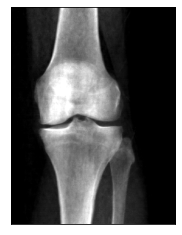

warped_image_B


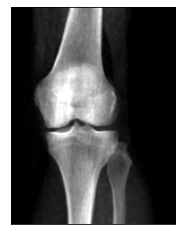

image_B


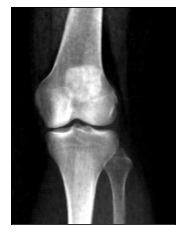

In [152]:
print("image to image registration on the test set")
print("image_A")
show(image_A[5, 0])
print("warped_image_B")
show(netGrad.warped_image_A[5, 0])
print("image_B")
show(image_B[5, 0])

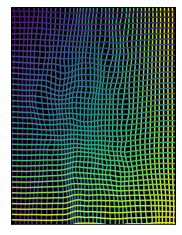

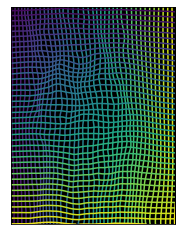

In [153]:
plt.contour(netGrad.phi_AB_vectorfield[5, 1].detach().cpu(), 40)
plt.contour(netGrad.phi_AB_vectorfield[5, 0].detach().cpu(), 40)
show(image_A[0, 0] * 0)
plt.contour(netGrad.phi_BA_vectorfield[5, 1].detach().cpu(), 40)
plt.contour(netGrad.phi_BA_vectorfield[5, 0].detach().cpu(), 40)
show(image_A[0, 0] * 0)

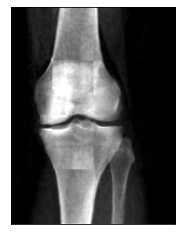

In [157]:
show(
    torch.tensor(
        itk.checker_board_image_filter(
            image_A[5, 0].cpu().numpy(), 
            netGrad.warped_image_B[5, 0].cpu().numpy()
        )
    )
)

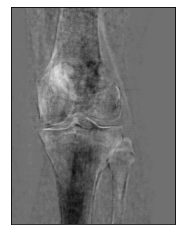

In [158]:
show((image_A[5, 0] - netGrad.warped_image_B[5, 0]))

In [159]:
netGrad.similarity = icon.ssd
netGrad.lmbda = .2

In [121]:
atlas = torch.nn.Parameter(torch.randn(1, 1, 845, 640, device="cuda"))
with torch.no_grad():
    atlas[:] = torch.mean(big_enough_knees, axis=0, keepdims=True)

atlas_exp = atlas.expand(BATCH_SIZE, -1, -1, -1).cuda()
params = [atlas]

In [122]:
optim = torch.optim.Adam(params, lr=.1)


In [138]:
for _ in range(1273):
    image_B = make_batch()
    optim.zero_grad()
    loss_obj = netGrad(atlas_exp, image_B)
    disp_direction_loss = torch.mean(torch.mean(netGrad.phi_AB_vectorfield - netGrad.identity_map, axis=0)**2)
    print(disp_direction_loss)
    (loss_obj.all_loss + 3 * disp_direction_loss).backward()
    optim.step()
    print(icon.losses.to_floats(loss_obj))

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010366884991526604, inverse_consistency_loss=0.009865520521998405, similarity_loss=0.008393781259655952, transform_magnitude=0.0023760602343827486, flips=0.0)
tensor(8.8906e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009811276569962502, inverse_consistency_loss=0.007888691499829292, similarity_loss=0.008233537897467613, transform_magnitude=0.0008489835890941322, flips=0.0)
tensor(7.1358e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010409043170511723, inverse_consistency_loss=0.008270075544714928, similarity_loss=0.008755028247833252, transform_magnitude=0.001092991093173623, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008696913719177246, inverse_consistency_loss=0.00841682218015194, similarity_loss=0.007013549096882343, transform_magnitude=0.001482969499193132, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackwa

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011890681460499763, inverse_consistency_loss=0.008916381746530533, similarity_loss=0.010107405483722687, transform_magnitude=0.0010936246253550053, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008762690238654613, inverse_consistency_loss=0.008221272379159927, similarity_loss=0.0071184360422194, transform_magnitude=0.0008954879594966769, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009833665564656258, inverse_consistency_loss=0.009511690586805344, similarity_loss=0.007931327447295189, transform_magnitude=0.0017756384331732988, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00998219195753336, inverse_consistency_loss=0.010100779123604298, similarity_loss=0.007962035946547985, transform_magnitude=0.002359375823289156, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICO

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00942812766879797, inverse_consistency_loss=0.009079020470380783, similarity_loss=0.007612323388457298, transform_magnitude=0.0012581575429067016, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009123402647674084, inverse_consistency_loss=0.008103635162115097, similarity_loss=0.007502675987780094, transform_magnitude=0.0011000402737408876, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008895966224372387, inverse_consistency_loss=0.008847886696457863, similarity_loss=0.007126388605684042, transform_magnitude=0.0017304609064012766, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009084581397473812, inverse_consistency_loss=0.008354609832167625, similarity_loss=0.007413659244775772, transform_magnitude=0.0010496509494259953, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)


tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010427362285554409, inverse_consistency_loss=0.009062696248292923, similarity_loss=0.00861482322216034, transform_magnitude=0.0016430964460596442, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010150603018701077, inverse_consistency_loss=0.009171910583972931, similarity_loss=0.008316220715641975, transform_magnitude=0.0013711643405258656, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009083299897611141, inverse_consistency_loss=0.0079697510227561, similarity_loss=0.007489349693059921, transform_magnitude=0.0013538387138396502, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008093984797596931, inverse_consistency_loss=0.008153600618243217, similarity_loss=0.006463265046477318, transform_magnitude=0.0012968580704182386, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
IC

tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00963800773024559, inverse_consistency_loss=0.008751400746405125, similarity_loss=0.007887727580964565, transform_magnitude=0.0015956111019477248, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009164898656308651, inverse_consistency_loss=0.008058442734181881, similarity_loss=0.007553210482001305, transform_magnitude=0.001693899743258953, flips=0.0)
tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009505689144134521, inverse_consistency_loss=0.008090050891041756, similarity_loss=0.007887679152190685, transform_magnitude=0.001767046982422471, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008608298376202583, inverse_consistency_loss=0.007826537825167179, similarity_loss=0.007042990997433662, transform_magnitude=0.0009226064430549741, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
IC

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009080814197659492, inverse_consistency_loss=0.007812401279807091, similarity_loss=0.007518334314227104, transform_magnitude=0.0009402199648320675, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008831621147692204, inverse_consistency_loss=0.007692508399486542, similarity_loss=0.007293119095265865, transform_magnitude=0.0012833945220336318, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008269453421235085, inverse_consistency_loss=0.008378678932785988, similarity_loss=0.006593717727810144, transform_magnitude=0.0015895561082288623, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00927578005939722, inverse_consistency_loss=0.009188447147607803, similarity_loss=0.00743809062987566, transform_magnitude=0.001350612030364573, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
IC

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00930737517774105, inverse_consistency_loss=0.0085308738052845, similarity_loss=0.007601200602948666, transform_magnitude=0.0013111656298860908, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008645731955766678, inverse_consistency_loss=0.008619101718068123, similarity_loss=0.006921911612153053, transform_magnitude=0.001771988463588059, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009508446790277958, inverse_consistency_loss=0.008686583489179611, similarity_loss=0.007771129719913006, transform_magnitude=0.0012960864696651697, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010843848809599876, inverse_consistency_loss=0.00898731965571642, similarity_loss=0.009046385064721107, transform_magnitude=0.0012678047642111778, flips=0.0)
tensor(9.3837e-05, device='cuda:0', grad_fn=<MeanBackward0>)


tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008653518743813038, inverse_consistency_loss=0.009371504187583923, similarity_loss=0.006779217626899481, transform_magnitude=0.002182702301070094, flips=0.0)
tensor(7.3592e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009803281165659428, inverse_consistency_loss=0.00901697389781475, similarity_loss=0.007999886758625507, transform_magnitude=0.0010329597862437367, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009398802183568478, inverse_consistency_loss=0.008222506381571293, similarity_loss=0.007754300720989704, transform_magnitude=0.0012150192633271217, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009000243619084358, inverse_consistency_loss=0.008784579113125801, similarity_loss=0.007243327330797911, transform_magnitude=0.0022691895719617605, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01154300756752491, inverse_consistency_loss=0.009024599567055702, similarity_loss=0.00973808765411377, transform_magnitude=0.001553881447762251, flips=0.0)
tensor(9.7478e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009586137719452381, inverse_consistency_loss=0.008195126429200172, similarity_loss=0.007947112433612347, transform_magnitude=0.0011683456832543015, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011892045848071575, inverse_consistency_loss=0.008790208026766777, similarity_loss=0.010134004056453705, transform_magnitude=0.001842369558289647, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009855453856289387, inverse_consistency_loss=0.008470747619867325, similarity_loss=0.008161304518580437, transform_magnitude=0.0015165056101977825, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)

tensor(8.9272e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00997252855449915, inverse_consistency_loss=0.008521588519215584, similarity_loss=0.008268211036920547, transform_magnitude=0.001041447278112173, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009762177243828773, inverse_consistency_loss=0.008356429636478424, similarity_loss=0.008090890944004059, transform_magnitude=0.001349973725154996, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010060501284897327, inverse_consistency_loss=0.008860273286700249, similarity_loss=0.008288446813821793, transform_magnitude=0.0023457349743694067, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01026848703622818, inverse_consistency_loss=0.008541710674762726, similarity_loss=0.008560145273804665, transform_magnitude=0.0021492447704076767, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)

tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008534926921129227, inverse_consistency_loss=0.007964969612658024, similarity_loss=0.006941933184862137, transform_magnitude=0.0011108005419373512, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00910502951592207, inverse_consistency_loss=0.008226737380027771, similarity_loss=0.007459682412445545, transform_magnitude=0.00162432249635458, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008749808184802532, inverse_consistency_loss=0.008049696683883667, similarity_loss=0.007139868568629026, transform_magnitude=0.001456511439755559, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008923586457967758, inverse_consistency_loss=0.008361691609025002, similarity_loss=0.007251248229295015, transform_magnitude=0.001947858021594584, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICON

tensor(6.8517e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009515349753201008, inverse_consistency_loss=0.008325654082000256, similarity_loss=0.007850218564271927, transform_magnitude=0.0006017340929247439, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01112501509487629, inverse_consistency_loss=0.009663568809628487, similarity_loss=0.009192300960421562, transform_magnitude=0.0016699933912605047, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00999185536056757, inverse_consistency_loss=0.009228107519447803, similarity_loss=0.008146233856678009, transform_magnitude=0.001557213137857616, flips=0.0)
tensor(5.3525e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010869098827242851, inverse_consistency_loss=0.009229292161762714, similarity_loss=0.009023240767419338, transform_magnitude=0.001101374626159668, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackwar

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009293729439377785, inverse_consistency_loss=0.008637914434075356, similarity_loss=0.007566146552562714, transform_magnitude=0.0013194751227274537, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010039246641099453, inverse_consistency_loss=0.00815403088927269, similarity_loss=0.0084084402769804, transform_magnitude=0.0013421089388430119, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00823764968663454, inverse_consistency_loss=0.008020223118364811, similarity_loss=0.0066336048766970634, transform_magnitude=0.001090128207579255, flips=0.0)
tensor(6.8847e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011890603229403496, inverse_consistency_loss=0.008820651099085808, similarity_loss=0.010126473382115364, transform_magnitude=0.0013551805168390274, flips=0.0)
tensor(8.6632e-05, device='cuda:0', grad_fn=<MeanBackwar

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.013019192032516003, inverse_consistency_loss=0.007882636040449142, similarity_loss=0.011442665010690689, transform_magnitude=0.0011952772038057446, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010177964344620705, inverse_consistency_loss=0.009407381527125835, similarity_loss=0.008296487852931023, transform_magnitude=0.0026823855005204678, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01008764747530222, inverse_consistency_loss=0.009093403816223145, similarity_loss=0.00826896633952856, transform_magnitude=0.0017973779467865825, flips=0.0)
tensor(8.1718e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010494611226022243, inverse_consistency_loss=0.008233864791691303, similarity_loss=0.008847838267683983, transform_magnitude=0.001081806025467813, flips=0.0)
tensor(7.5251e-05, device='cuda:0', grad_fn=<MeanBackwa

tensor(8.7741e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008466721512377262, inverse_consistency_loss=0.007097309455275536, similarity_loss=0.007047259248793125, transform_magnitude=0.0007284104940481484, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009624281898140907, inverse_consistency_loss=0.008883969858288765, similarity_loss=0.007847487926483154, transform_magnitude=0.0016074820887297392, flips=0.0)
tensor(6.1626e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008036129176616669, inverse_consistency_loss=0.00751258060336113, similarity_loss=0.006533613428473473, transform_magnitude=0.0010915789753198624, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009256704710423946, inverse_consistency_loss=0.007833660580217838, similarity_loss=0.007689972408115864, transform_magnitude=0.0011724754003807902, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBack

tensor(5.6765e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008152591064572334, inverse_consistency_loss=0.00826258771121502, similarity_loss=0.006500073242932558, transform_magnitude=0.0010488561820238829, flips=0.0)
tensor(8.5720e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010485109873116016, inverse_consistency_loss=0.008517395704984665, similarity_loss=0.008781630545854568, transform_magnitude=0.0015542061300948262, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010367373004555702, inverse_consistency_loss=0.00868375226855278, similarity_loss=0.008630622178316116, transform_magnitude=0.001329468097537756, flips=0.0)
tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009117938578128815, inverse_consistency_loss=0.009959309361875057, similarity_loss=0.0071260761469602585, transform_magnitude=0.002739780116826296, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackwa

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010858328081667423, inverse_consistency_loss=0.009198714047670364, similarity_loss=0.009018585085868835, transform_magnitude=0.0012223818339407444, flips=0.0)
tensor(9.8947e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01043860986828804, inverse_consistency_loss=0.008800522424280643, similarity_loss=0.008678505197167397, transform_magnitude=0.0008227135986089706, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008644710294902325, inverse_consistency_loss=0.008606236428022385, similarity_loss=0.006923463195562363, transform_magnitude=0.0015165760414674878, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00906565971672535, inverse_consistency_loss=0.008242130279541016, similarity_loss=0.007417233195155859, transform_magnitude=0.0009080853196792305, flips=0.0)
tensor(4.6012e-05, device='cuda:0', grad_fn=<MeanBackw

tensor(7.6507e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00925760343670845, inverse_consistency_loss=0.0076397377997636795, similarity_loss=0.007729656063020229, transform_magnitude=0.0004955463227815926, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009139574132859707, inverse_consistency_loss=0.008409724570810795, similarity_loss=0.007457628846168518, transform_magnitude=0.0011736898450180888, flips=0.0)
tensor(6.5766e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008027328178286552, inverse_consistency_loss=0.007239542901515961, similarity_loss=0.006579420063644648, transform_magnitude=0.0008032299228943884, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010902469046413898, inverse_consistency_loss=0.011297348886728287, similarity_loss=0.008642999455332756, transform_magnitude=0.003656945424154401, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBack

tensor(8.0110e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010352281853556633, inverse_consistency_loss=0.008570991456508636, similarity_loss=0.008638083934783936, transform_magnitude=0.0015988040249794722, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009538480080664158, inverse_consistency_loss=0.008477937430143356, similarity_loss=0.007842892780900002, transform_magnitude=0.0008110679918900132, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00890171155333519, inverse_consistency_loss=0.008351962082087994, similarity_loss=0.007231319323182106, transform_magnitude=0.001457597711123526, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010701888240873814, inverse_consistency_loss=0.008445844985544682, similarity_loss=0.009012719616293907, transform_magnitude=0.0015673729358240962, flips=0.0)
tensor(9.8443e-05, device='cuda:0', grad_fn=<MeanBackw

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011492075398564339, inverse_consistency_loss=0.010451899841427803, similarity_loss=0.009401695802807808, transform_magnitude=0.003090015146881342, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009367323480546474, inverse_consistency_loss=0.008516439236700535, similarity_loss=0.007664036005735397, transform_magnitude=0.0009959188755601645, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011318893171846867, inverse_consistency_loss=0.009642086923122406, similarity_loss=0.009390476159751415, transform_magnitude=0.0015919340075924993, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010221931152045727, inverse_consistency_loss=0.008898409083485603, similarity_loss=0.008442249149084091, transform_magnitude=0.0016332613304257393, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)


tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010908437892794609, inverse_consistency_loss=0.009512543678283691, similarity_loss=0.009005929343402386, transform_magnitude=0.0017874815966933966, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008744851686060429, inverse_consistency_loss=0.009482961148023605, similarity_loss=0.006848259828984737, transform_magnitude=0.0027760600205510855, flips=0.0)
tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009007003158330917, inverse_consistency_loss=0.008485889062285423, similarity_loss=0.007309825159609318, transform_magnitude=0.0019024350913241506, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01016024500131607, inverse_consistency_loss=0.007698518689721823, similarity_loss=0.008620541542768478, transform_magnitude=0.0008642136817798018, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)


tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009073330089449883, inverse_consistency_loss=0.007515450939536095, similarity_loss=0.007570240180939436, transform_magnitude=0.000928727095015347, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00811797846108675, inverse_consistency_loss=0.007413060404360294, similarity_loss=0.006635366007685661, transform_magnitude=0.0010153313633054495, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010554429143667221, inverse_consistency_loss=0.008556658402085304, similarity_loss=0.00884309783577919, transform_magnitude=0.0022166939452290535, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008395707234740257, inverse_consistency_loss=0.0074202073737978935, similarity_loss=0.006911666132509708, transform_magnitude=0.0009747051517479122, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
I

tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009753018617630005, inverse_consistency_loss=0.00860295444726944, similarity_loss=0.008032428100705147, transform_magnitude=0.001157302176579833, flips=0.0)
tensor(8.2940e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010889802128076553, inverse_consistency_loss=0.008101945742964745, similarity_loss=0.009269412606954575, transform_magnitude=0.0010669886833056808, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008416046388447285, inverse_consistency_loss=0.008956984616816044, similarity_loss=0.006624649744480848, transform_magnitude=0.00224472489207983, flips=0.0)
tensor(8.2678e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00831646379083395, inverse_consistency_loss=0.00786922313272953, similarity_loss=0.006742618978023529, transform_magnitude=0.0011732514249160886, flips=0.0)
tensor(9.4975e-05, device='cuda:0', grad_fn=<MeanBackw

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00825472828000784, inverse_consistency_loss=0.0074309902265667915, similarity_loss=0.006768530234694481, transform_magnitude=0.0009627688559703529, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008699663914740086, inverse_consistency_loss=0.00792006216943264, similarity_loss=0.007115651853382587, transform_magnitude=0.0014912999467924237, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008510046638548374, inverse_consistency_loss=0.00848006084561348, similarity_loss=0.006814034655690193, transform_magnitude=0.0007689654594287276, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009450086392462254, inverse_consistency_loss=0.007702181581407785, similarity_loss=0.007909649983048439, transform_magnitude=0.0009267821442335844, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
I

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008669747970998287, inverse_consistency_loss=0.008381257764995098, similarity_loss=0.006993496790528297, transform_magnitude=0.00142000918276608, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010249071754515171, inverse_consistency_loss=0.00880579836666584, similarity_loss=0.008487911894917488, transform_magnitude=0.0015188222751021385, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.007672117091715336, inverse_consistency_loss=0.008257651701569557, similarity_loss=0.006020586937665939, transform_magnitude=0.0013226261362433434, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008961106650531292, inverse_consistency_loss=0.008375559002161026, similarity_loss=0.007285994477570057, transform_magnitude=0.0016432605916634202, flips=0.0)
tensor(4.2348e-05, device='cuda:0', grad_fn=<MeanBackward0>

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.012426660396158695, inverse_consistency_loss=0.012007251381874084, similarity_loss=0.010025209747254848, transform_magnitude=0.0014348566764965653, flips=0.0)
tensor(6.4503e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010689545422792435, inverse_consistency_loss=0.009126085788011551, similarity_loss=0.008864328265190125, transform_magnitude=0.0015099021838977933, flips=0.0)
tensor(5.5991e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010508636943995953, inverse_consistency_loss=0.00984259508550167, similarity_loss=0.008540118113160133, transform_magnitude=0.0010416528675705194, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.01438799686729908, inverse_consistency_loss=0.010730503126978874, similarity_loss=0.012241896241903305, transform_magnitude=0.0021022544242441654, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackw

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009366580285131931, inverse_consistency_loss=0.008194244466722012, similarity_loss=0.007727731019258499, transform_magnitude=0.001299226307310164, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010514171794056892, inverse_consistency_loss=0.008716166019439697, similarity_loss=0.008770938962697983, transform_magnitude=0.0005359054775908589, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009797810576856136, inverse_consistency_loss=0.00912761501967907, similarity_loss=0.007972287945449352, transform_magnitude=0.0019261650741100311, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009474404156208038, inverse_consistency_loss=0.009921536780893803, similarity_loss=0.007490096613764763, transform_magnitude=0.003042849712073803, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
IC

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009852972812950611, inverse_consistency_loss=0.008375908248126507, similarity_loss=0.00817779079079628, transform_magnitude=0.0012863869778811932, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009693469852209091, inverse_consistency_loss=0.008141889236867428, similarity_loss=0.008065092377364635, transform_magnitude=0.0009887118358165026, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00931272841989994, inverse_consistency_loss=0.008431948721408844, similarity_loss=0.007626338861882687, transform_magnitude=0.0011754423612728715, flips=0.0)
tensor(3.1989e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009723152965307236, inverse_consistency_loss=0.007882190868258476, similarity_loss=0.00814671441912651, transform_magnitude=0.0007188372546806931, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009398873895406723, inverse_consistency_loss=0.00946212001144886, similarity_loss=0.007506449706852436, transform_magnitude=0.0008971116621978581, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010442123748362064, inverse_consistency_loss=0.009055479429662228, similarity_loss=0.008631028234958649, transform_magnitude=0.0015646389219909906, flips=0.0)
tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009523795917630196, inverse_consistency_loss=0.008890177123248577, similarity_loss=0.00774576049298048, transform_magnitude=0.0025569105055183172, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00939327385276556, inverse_consistency_loss=0.008742457255721092, similarity_loss=0.007644782308489084, transform_magnitude=0.0015486526535823941, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
IC

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009500715881586075, inverse_consistency_loss=0.008777542039752007, similarity_loss=0.007745207753032446, transform_magnitude=0.0017672235844656825, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011853029951453209, inverse_consistency_loss=0.00913152750581503, similarity_loss=0.010026724077761173, transform_magnitude=0.0016102114459499717, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010576958768069744, inverse_consistency_loss=0.009162457659840584, similarity_loss=0.008744467049837112, transform_magnitude=0.0014398188795894384, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00956529751420021, inverse_consistency_loss=0.008572475984692574, similarity_loss=0.00785080250352621, transform_magnitude=0.001227071275934577, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICO

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008884543552994728, inverse_consistency_loss=0.008271222934126854, similarity_loss=0.0072302985936403275, transform_magnitude=0.0017893401673063636, flips=0.0)
tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008323049172759056, inverse_consistency_loss=0.008403608575463295, similarity_loss=0.006642327643930912, transform_magnitude=0.0017729132669046521, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011646629311144352, inverse_consistency_loss=0.008681198582053185, similarity_loss=0.00991038978099823, transform_magnitude=0.0014421686064451933, flips=0.0)
tensor(9.0776e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009413390420377254, inverse_consistency_loss=0.00856910552829504, similarity_loss=0.007699569687247276, transform_magnitude=0.0013907273532822728, flips=0.0)
tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward

tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010549133643507957, inverse_consistency_loss=0.009274708107113838, similarity_loss=0.00869419239461422, transform_magnitude=0.0019246325828135014, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010228076949715614, inverse_consistency_loss=0.008724536746740341, similarity_loss=0.008483169600367546, transform_magnitude=0.0018037789268419147, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009326540865004063, inverse_consistency_loss=0.009422591887414455, similarity_loss=0.0074420226737856865, transform_magnitude=0.0017441952368244529, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009517978876829147, inverse_consistency_loss=0.00868133082985878, similarity_loss=0.0077817123383283615, transform_magnitude=0.0014572145882993937, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009042014367878437, inverse_consistency_loss=0.00791165791451931, similarity_loss=0.007459682412445545, transform_magnitude=0.0011899422388523817, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009844392538070679, inverse_consistency_loss=0.007783126085996628, similarity_loss=0.008287766948342323, transform_magnitude=0.0011190061923116446, flips=0.0)
tensor(8.6453e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009229166433215141, inverse_consistency_loss=0.00862624030560255, similarity_loss=0.007503918372094631, transform_magnitude=0.0008645436028018594, flips=0.0)
tensor(8.0490e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009218503721058369, inverse_consistency_loss=0.009001389145851135, similarity_loss=0.007418225519359112, transform_magnitude=0.0017314479919150472, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackw

tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009798659011721611, inverse_consistency_loss=0.007513989694416523, similarity_loss=0.008295861072838306, transform_magnitude=0.0013866354711353779, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.007752295583486557, inverse_consistency_loss=0.00760419899597764, similarity_loss=0.006231455598026514, transform_magnitude=0.0015832792269065976, flips=0.0)
tensor(9.3547e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010602254420518875, inverse_consistency_loss=0.008524230681359768, similarity_loss=0.008897407911717892, transform_magnitude=0.0018020494608208537, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008358046412467957, inverse_consistency_loss=0.008192033506929874, similarity_loss=0.006719639524817467, transform_magnitude=0.0014753963332623243, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward

tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009240432642400265, inverse_consistency_loss=0.007827647030353546, similarity_loss=0.007674903608858585, transform_magnitude=0.0016102308873087168, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.00892304815351963, inverse_consistency_loss=0.008351707831025124, similarity_loss=0.007252706680446863, transform_magnitude=0.0015246595721691847, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.007852690294384956, inverse_consistency_loss=0.00806647352874279, similarity_loss=0.006239396054297686, transform_magnitude=0.001417837804183364, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009171600453555584, inverse_consistency_loss=0.008475404232740402, similarity_loss=0.007476519793272018, transform_magnitude=0.002041697036474943, flips=0.0)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)
ICO

tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009633379057049751, inverse_consistency_loss=0.007919955998659134, similarity_loss=0.008049387484788895, transform_magnitude=0.0015390781918540597, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010723987594246864, inverse_consistency_loss=0.008185554295778275, similarity_loss=0.00908687710762024, transform_magnitude=0.0014333997387439013, flips=0.0)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009151029400527477, inverse_consistency_loss=0.008445610292255878, similarity_loss=0.007461907342076302, transform_magnitude=0.001701585715636611, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.011111145839095116, inverse_consistency_loss=0.007970670238137245, similarity_loss=0.009517012163996696, transform_magnitude=0.0006664926186203957, flips=0.0)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)
I

tensor(9.8367e-05, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008271509781479836, inverse_consistency_loss=0.00765928253531456, similarity_loss=0.006739653646945953, transform_magnitude=0.0008766453247517347, flips=0.0)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.010147162713110447, inverse_consistency_loss=0.009066129103302956, similarity_loss=0.008333937264978886, transform_magnitude=0.002531897509470582, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.008827422745525837, inverse_consistency_loss=0.00834092777222395, similarity_loss=0.0071592372842133045, transform_magnitude=0.0013568858848884702, flips=0.0)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
ICONLoss(all_loss=0.009271332994103432, inverse_consistency_loss=0.00950855016708374, similarity_loss=0.007369623053818941, transform_magnitude=0.0023612380027770996, flips=0.0)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>

In [170]:
image_B = test_imgs.cuda()
with torch.no_grad():
    netGrad(atlas.expand(10, -1, -1, -1).cuda(), image_B)

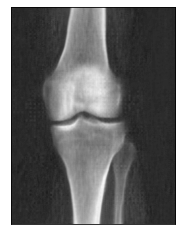

In [171]:
show(atlas[0, 0])


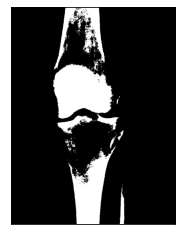

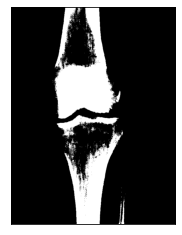

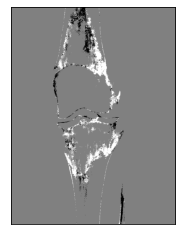

In [172]:
show(image_B[0, 0] > .5)
show(netGrad.warped_image_A[0, 0]> .5)
show((netGrad.warped_image_A[0, 0] > .5)* 1. - (image_B[0, 0] > .5) * 1.)

image


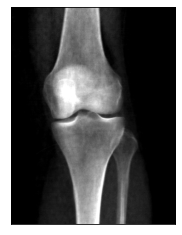

warped_atlas


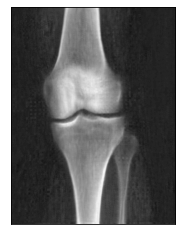

difference image


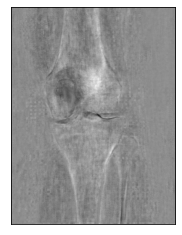

In [176]:
print("image")
show(image_B[0, 0])
print("warped_atlas")
show(netGrad.warped_image_A[0, 0])
print("difference image")
show((netGrad.warped_image_A[0, 0]) - (image_B[0, 0]))

In [174]:
len(big_enough_knees)

123

image


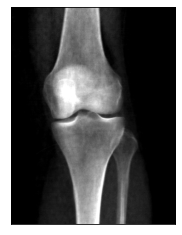

warped_atlas


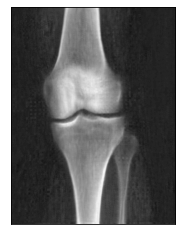

difference image


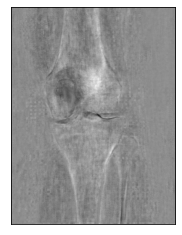

image


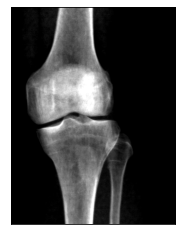

warped_atlas


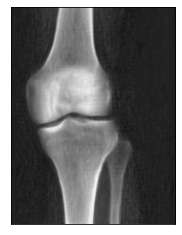

difference image


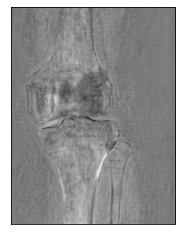

image


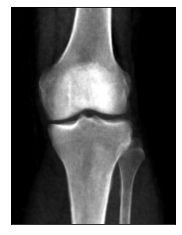

warped_atlas


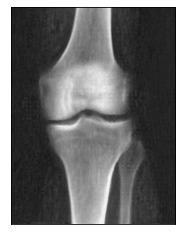

difference image


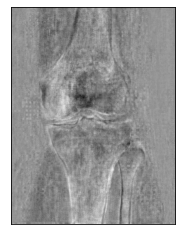

image


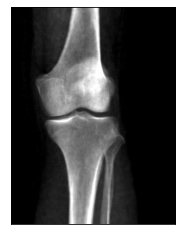

warped_atlas


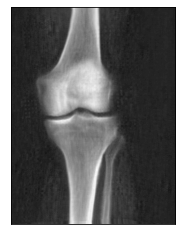

difference image


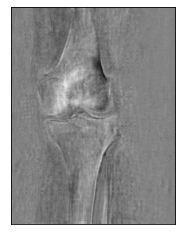

image


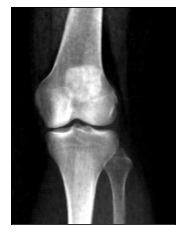

warped_atlas


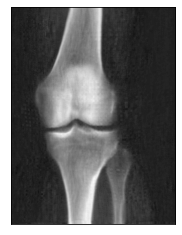

difference image


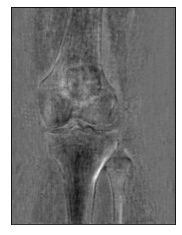

image


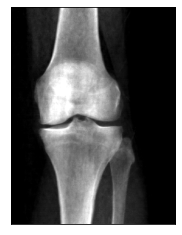

warped_atlas


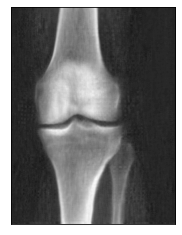

difference image


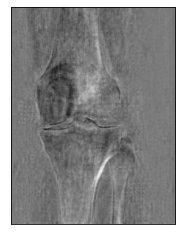

image


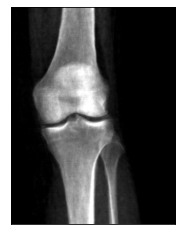

warped_atlas


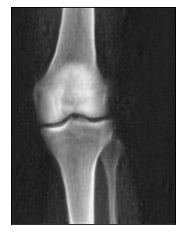

difference image


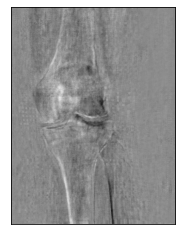

image


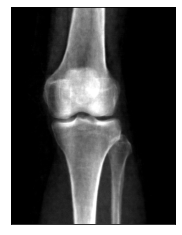

warped_atlas


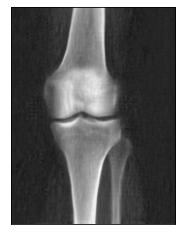

difference image


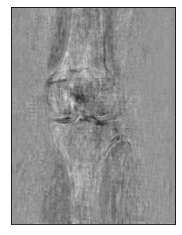

image


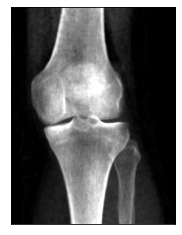

warped_atlas


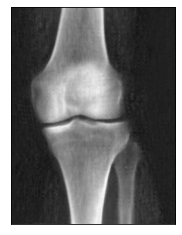

difference image


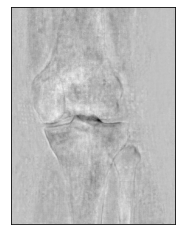

image


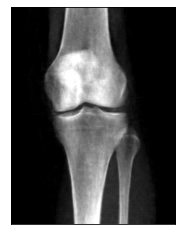

warped_atlas


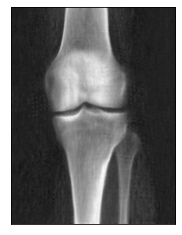

difference image


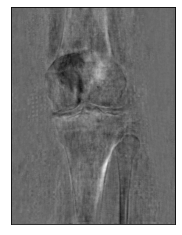

In [177]:
for N in range(10):
    print("image")
    show(image_B[N, 0])
    print("warped_atlas")
    show(netGrad.warped_image_A[N, 0])
    print("difference image")
    show((netGrad.warped_image_A[N, 0]) - (image_B[N, 0]))